In [10]:
from jax import numpy as jnp
from typing import Tuple,Dict, Callable, List, Any
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpyro
from pathlib import WindowsPath,PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
import pickle
from common_util import setup_axis_default, jmak_fit_model_setup,gl_fit_model_setup,kbar_jmak,kbar_gl,tbar,get_data_multiplier,\
                        _FILE_TO_LABEL as file_to_label

from typing import List, Dict, Tuple
from numpyro.distributions import Distribution
from statsmodels.regression.linear_model import OLS, OLSResults
from jax import vmap
from numpyro.distributions import MultivariateNormal, Uniform
from matplotlib import rc

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

def normal_prior_lm(name: str,
                    params: Tuple[jnp.ndarray| np.ndarray],
                    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]) -> Tuple[str,Distribution,Callable]:

    """
    make a linear latent model with a normal prior on the parameters, specified by 
    the mean and covariance.

    Args:
    ---------
    name: str
        the name of the latent model
    params: Tuple[jnp.ndarray| np.ndarray]
        the mean and covariance of the normal prior
    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]
        the transformation to apply to the latent variables before applying the linear model

    Returns:
    ---------
    Tuple[str,Distribution,Callable]
    The name, distribution, and latent model function, with a None placeholder for sampled parameters
    """
    def linear_latent_model(x: jnp.ndarray,p: jnp.ndarray):
        x_ = latent_transform(x)
        y = jnp.sum(x_ * p,axis = -1)
        return y

    return [name,MultivariateNormal(params[0],params[1]),linear_latent_model,None]

def uniform_prior_lm(name: str,
                    params: Tuple[jnp.ndarray| np.ndarray],
                    latent_transform: Callable[[jnp.ndarray],jnp.ndarray]) -> Tuple[str,Distribution,Callable]:

    """
    Effectively the same as normal_prior_lm, but with a uniform prior on the parameters
    """
    def linear_latent_model(x: jnp.ndarray,p: jnp.ndarray):
        x_ = latent_transform(x)
        y = jnp.sum(x_ * p,axis = -1)
        return y

    a = params[0] - 3.0*jnp.sqrt(params[1])
    b = params[0] + 3.0*jnp.sqrt(params[1])
    return [name,Uniform(a,b),linear_latent_model,None]

def statsmodels_lm_to_bayesian(name: str,
                               ols: OLSResults,
                               latent_transform: Callable[[jnp.ndarray],jnp.ndarray],
                               prior = 'normal') -> Tuple[str,
                                                        Distribution,
                                                        Callable]:

    """
    utility to convert a statsmodels OLS model to a bayesian model with a normal or uniform prior
    """
    try:
        return {'normal':normal_prior_lm(name,(ols.params,5*ols.cov_params()),latent_transform),
        'uniform':uniform_prior_lm(name,(ols.params,5*np.diag(ols.cov_params())),latent_transform)}[prior]
    except KeyError:
        raise ValueError('Invalid prior type. Must be one of "normal" or "uniform"')


def slm(latent_model_tuple: List[Any], 
        latent_variable: jnp.ndarray,
        params: jnp.ndarray) -> jnp.ndarray:
    """
    sample latent model output from provided samples
    """
    _,_,latent_model,_ = latent_model_tuple
    latent_model_tuple[-1] = params
    return latent_model(latent_variable,params)

#affine transformations for the latent variables
def log_kbar_tform(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([jnp.ones([x.shape[0],1]),x[...,0:1]],axis = 1)

def log_tbar_tform(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.concatenate([jnp.ones([x.shape[0],1]),x[...,1:2]],axis = 1)

### Compare The Posterior Predictives
of the JMAK model of single-inference vs. Combined Inference. 

No standard deviation column found, using 0.001 for all values
No standard deviation column found, using 0.001 for all values


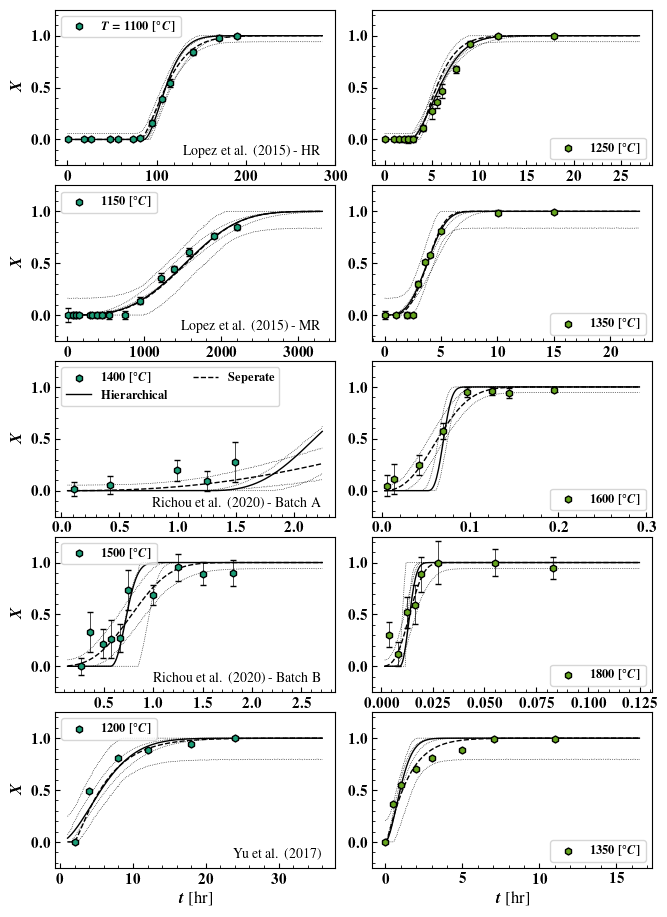

In [ ]:
from common_util import get_data_label  
from matplotlib.lines import Line2D
from numpyro.distributions import Normal, LogNormal, TruncatedNormal
from jax import random
rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)

def jmak_posterior_predictive(t: jnp.ndarray,
                              T: jnp.ndarray,
                              latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                              a1_coeff: jnp.ndarray,
                              B1_coeff: jnp.ndarray,
                              n_coeff: jnp.ndarray,
                              a2_coeff: jnp.ndarray,
                              B2_coeff: jnp.ndarray,
                              latent_variables : jnp.ndarray) -> jnp.ndarray:
    
    #sample the latent model variables and latent parameters
    a1 = slm(latent_models['a1'],latent_variables,a1_coeff)[np.newaxis,...]
    B1 = slm(latent_models['B1'],latent_variables,B1_coeff)[np.newaxis,...]
    n = slm(latent_models['n'],latent_variables,n_coeff)[np.newaxis,...]
    a2 = slm(latent_models['a2'],latent_variables,a2_coeff)[np.newaxis,...]
    B2 = slm(latent_models['B2'],latent_variables,B2_coeff)[np.newaxis,...]

    #compute the model prediction using the samples
    b = np.exp(a1 + B1/T[...,np.newaxis])
    t_inc = np.exp(a2 + B2/T[...,np.newaxis])
    t_eff = t[...,np.newaxis] - t_inc
    t_eff[t_eff < 0.] = 0.0   

    Xhat = 1.0 - np.exp(-b**n*t_eff**n)
    return Xhat

def gl_posterior_predictive(t: jnp.ndarray,
                            T: jnp.ndarray,
                            latent_models: Dict[str,Tuple[jnp.ndarray,Callable]],
                            a1_coeff: jnp.ndarray,
                            B1_coeff: jnp.ndarray,
                            nu_coeff: jnp.ndarray,
                            a2_coeff: jnp.ndarray,
                            B2_coeff: jnp.ndarray,
                            latent_variables : jnp.ndarray) -> jnp.ndarray:
    
    a1 = slm(latent_models['a1'],latent_variables,a1_coeff)[np.newaxis,...]
    B1 = slm(latent_models['B1'],latent_variables,B1_coeff)[np.newaxis,...]
    nu = slm(latent_models['nu'],latent_variables,nu_coeff)[np.newaxis,...]
    a2 = slm(latent_models['a2'],latent_variables,a2_coeff)[np.newaxis,...]
    B2 = slm(latent_models['B2'],latent_variables,B2_coeff)[np.newaxis,...]

    B = np.exp(a1 + B1/T[...,np.newaxis])
    M = np.exp(a2 + B2/T[...,np.newaxis])

    Xhat = (1.+ np.exp(-B*(t[...,np.newaxis] - M)))**(-1./nu)
    return Xhat

def jmak_model(t: np.ndarray,T:np.ndarray,a1: float,B1: float,a2: float,B2: float,n: float) -> np.ndarray:
    """
    So we can just plug in a point estimate easily
    """
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0 - np.exp(-b**n*(np.where(t > t_inc, t,t_inc) - t_inc)**n)

def jmak_numpyro_model(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      pmean: jnp.ndarray,
                      pstd: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1 = numpyro.sample('a1',Normal(pmean[0],pstd[0]))
    a2 = numpyro.sample('a2',Normal(pmean[2],pstd[2]))
    B1 = numpyro.sample('B1',Normal(pmean[1],pstd[1]))
    B2 = numpyro.sample('B2',Normal(pmean[3],pstd[3]))
    n = numpyro.sample('n',LogNormal(pmean[4]/2))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',TruncatedNormal(Xhat,scale = sigma + std,low = 0.0,high = 1.0),obs = X)

def plot_posterior_prediction_seperate(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: np.ndarray,
                              posterior_predictive: numpyro.infer.Predictive,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    data = exp_data.loc[exp_data['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    predictions = posterior_predictive(rng_key_,t = jnp.array(t),
                                                    T = jnp.ones_like(t)*temperature + 273.15,
                                                    X = None,
                                                    std = jnp.zeros_like(t),
                                                    pmean = np.empty_like(ml_est),
                                                    pstd = np.empty_like(ml_est))

    #Estimate using ML parameters
    ml_pred = model_func(t,(temperature + 273.15)*np.ones_like(t),
                        *ml_est)

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions['obs'],0.95)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    


def plot_posterior_prediction(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: Dict[str,np.ndarray], 
                              temperature: float,
                              exp_data: pd.DataFrame,
                              posterior_samples: Dict[str,np.ndarray],
                              latent_models: Dict[str,Tuple[np.ndarray,Callable]],
                              style: str = '-',
                              pred_color: str = 'k',
                              model_params = ['a1','B1','n','a2','B2','latent_variables']) -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    data = exp_data.loc[df['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    predictions = model_func(t,(temperature + 273.15)*np.ones_like(t),
                             latent_models,*(posterior_samples[key] for key in model_params))

    #Estimate using ML parameters
    ml_pred = model_func(t,(temperature + 273.15)*np.ones_like(t),
                        latent_models,*(ml_est[key][np.newaxis,:] for key in model_params))

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions.T,0.95)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    
def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[df['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 25,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

#plot the posterior predictive for the JMAK and GLM models for some sample isothermal temperatures
fig,axes = plt.subplots(nrows = 5,ncols = 2,figsize = (6.5,9))

file_to_index = {file: i for i,file in enumerate(list(file_to_label.keys()))}   
temperatures  = {'alfonso_data/highly_rolled.csv': [1100,1250],
                'alfonso_data/moderate_roll.csv': [1150,1350],
                'richou_data/batch_a_data.csv': [1400,1600],
                'richou_data/batch_b_data.csv': [1500,1800],
                 'yu_data/data.csv': [1200,1350]}

temperatures = {get_data_label(DATA_DIR.joinpath(file)): temps for file,temps in temperatures.items()}

model_name = 'JMAK_{}'
model_func = jmak_posterior_predictive
model_setup = jmak_fit_model_setup
ep_param = 'n'
color  = 'k'
style = '-'
numpyro_model = jmak_numpyro_model
model_func_seperate = jmak_model

#hierarchical model
with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_samples.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)

with open(INFERENCE_PATH.joinpath(f'{model_name.format("hierarchical")}_trunc_normal_params.pkl'),'rb') as f:
    inf_summary = pickle.load(f)

with open(INFERENCE_PATH.joinpath(f'{model_name.format('prior_linear_models_trunc_normal')}.pkl'),'rb') as f:  
    linear_models = pickle.load(f)

latent_models = {param: statsmodels_lm_to_bayesian(param,linear_models[param],log_kbar_tform,prior = 'uniform') for param in ['a1','B1',ep_param]}
latent_models.update({param: statsmodels_lm_to_bayesian(param,linear_models[param],log_tbar_tform,prior = 'uniform') for param in ['a2','B2']})

ml_params = inf_summary['ml']
ml_latent_var = ml_params['latent_variables'].copy()
posterior_samples_latent_var= posterior_samples['latent_variables'].copy()

for i,file in enumerate(list(file_to_label.keys())[:-1]): #count rows/datasets
    ml_params['latent_variables'] = ml_latent_var[file_to_index[file]]
    posterior_samples['latent_variables'] = posterior_samples_latent_var[:,file_to_index[file],:]
    t,T,X,df,bounds,p0 = model_setup(file, mult = get_data_multiplier(file))    
    for j,plot_temperature,exp_color in zip(range(2),temperatures[get_data_label(file)],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
        plot_posterior_prediction(axes[i,j],model_func,ml_params,
                                    plot_temperature,df,posterior_samples,latent_models,style = style,pred_color = color,
                                model_params = ['a1','B1',ep_param,'a2','B2','latent_variables'])
        plot_experimental_data(axes[i,j],df,plot_temperature,exp_color,first_label = (i == 0 and j == 0),
                                make_label = True)

for i,file in enumerate(list(file_to_label.keys())[:-1]): #count rows/datasets
    with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_samples.pkl'),'rb') as f:
        posterior_samples = pickle.load(f)

    posterior_predictive = numpyro.infer.Predictive(numpyro_model,
                                                    posterior_samples= posterior_samples)


    ipath = INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_params.csv')
    inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_trunc_normal_params.csv'),index_col = 0)
    model_params = ['a1','B1','a2','B2','n','sigma'] if 'JMAK' in model_name else ['a1','B1','a2','B2','nu','sigma']
    a1,B1,a2,B2,n,_ = inf_summary.loc[model_params,'ml'].to_numpy()

    t,T,X,df,bounds,p0 = model_setup(file, mult = get_data_multiplier(file))

    for j,plot_temperature,exp_color in zip(range(2),temperatures[get_data_label(file)],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
        plot_posterior_prediction_seperate(axes[i,j],model_func_seperate,np.array([a1,B1,a2,B2,n]),
                                    posterior_predictive,plot_temperature,df,style = '--',pred_color = color)
            
for ax,data_label in zip(axes[:,0],file_to_label.values()):
    ax.set_ylabel(r'$X$',fontsize = 12)
    ax.text(0.95, 0.05,r'\textbf{' + data_label + '}', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

for ax in axes[-1,:]:
    ax.set_xlabel(r'$t$ [hr]',fontsize = 12)

for i in range(5):
    for j in range(2):
        setup_axis_default(axes[i,j])
        axes[i,j].set_ylim([-0.25,1.25])
        #ax.set_xscale('log')   
        #final formatting

        if i == 2 and j == 0: 
            legend_patches  = [Line2D([],[],color = 'k',lw = 1.0,ls = '-',label = 'Hierarchical'),
                            Line2D([],[],color = 'k',lw = 1.0,ls = '--',label = 'Seperate')]
            handles,axes_labels = axes[i,j].get_legend_handles_labels()
            axes[i,j].legend(handles + legend_patches,
                             axes_labels + [r'\textbf{Hierarchical}',r'\textbf{Seperate}'],
                             fontsize = 9,ncol = 2,loc = 'upper left')
        elif j == 1:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'lower right')
        else:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'upper left')
        

fig.tight_layout(pad = 0.1) 
fig.savefig(GIT_IMAGE_PATH.joinpath('posterior_predictive_comparison_hierarchical_seperate.svg'))
